# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:30<00:00, 1730.08it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similarly doing preprocessing for reviews summary

#printing some random values of summary

summ_0 = final["Summary"].values[0]
print(summ_0)

summ_1500 = final["Summary"].values[1500]
print(summ_1500)

EVERY book is educational
Would be best if Canola Oil was left out


In [26]:
#removing urls
#removing all html tags
#contracting words 
#removing words with number
#removing words with special character
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
preprocessed_reviews_summary = []

from tqdm import tqdm
for summary in tqdm(final["Summary"].values):
    summary = re.sub(r"http\S+", "" ,summary)
    summary = BeautifulSoup(summary,"lxml").get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z]+', ' ', summary)
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(summary.strip())
    

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:07<00:00, 2867.07it/s]


# [5] Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

In [73]:
#importing important modules
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.naive_bayes import MultinomialNB
from sklearn import neighbors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [34]:
print(final.shape)
print("*************************************************")

##adding cleaned_text column to the final dataframe
final["cleaned_text"] = preprocessed_reviews

print(final.shape)
print("*************************************************************************************")

#checking if any missing values is present in the reviews.
final = final.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

print(final.shape)

final.head()


(364171, 10)
*************************************************
(364171, 11)
*************************************************************************************
(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


#### OBSERVATION:
1. No missing values are found in the given data.<br>
 

In [35]:
final["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

#### OBSERVATION:
The dataset consists of 307061 positive reviews and 57110 negative reviews.

In [36]:
#Randomly taking 50000 points from each positive and negative reviews due to less memory capacity
data_pos = final[final["Score"] ==1.0].sample(n = 50000)
data_neg = final[final["Score"] ==0.0].sample(n = 50000)


#concatenating the positive and negative reviews data 
final_cleaned_data = pd.concat([data_pos,data_neg],axis=0)

print(final_cleaned_data.shape)
final_cleaned_data.head()

(100000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
250943,272078,B005CMA4OI,A1EBARYXAWXPOG,HarshAve,0,0,1,1330473600,You're The Best A-ROOOOOOOOOUND,This is my sauce. I claim it. You all stick ...,sauce claim stick tabascos franks whatever els...
473654,512245,B0029K3EJS,A2IMHO3P54QFYJ,Tammy L. Tappan,1,1,1,1279756800,Perfect Pumpkin for Cooking,"The stores were out of canned pumpkin, & I lov...",stores canned pumpkin love make pumpkin spice ...
106259,115361,B000F4F952,A15N5VDROBEZ50,S. Robinson,0,0,1,1186876800,Top tea - Bottom price.,My wife is Australian and loves her tea. She ...,wife australian loves tea practically drank tw...
88770,96614,B001ELL4FY,A31D9IPL1YB8OM,"NY Teacher ""NY Teacher""",1,1,1,1332201600,Tully's Rocks My Mornings,I don't know what we did wrong here in NY that...,not know wrong ny got starbucks seattle kept t...
285841,309647,B000NMFXSY,A1URABY52WR0U6,D. Kokowski,1,1,1,1285804800,It's All Good!,I ordered this from AmericaRX and it was excel...,ordered americarx excellent swift delivery min...


The Amazon food fine reviews dataset include products having reviews at different time/year, considering time as feature.<br> So, sorting the dataset by time for increasing model performance.

#### Note:
Time based splitting of the reviews.

In [37]:
#time based splitting of the data
#converting time to date and time
final_cleaned_data["Time"] = pd.to_datetime(final_cleaned_data["Time"],unit="s")
final_cleaned_data = final_cleaned_data.sort_values(by = "Time")
final_cleaned_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining not he...
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happens say name three times michael keaten st...
121041,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,1,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,recently purchased woodstream corp gopher trap...
346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,2000-10-03,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,beetlejuice awe inspiring wonderfully amusing ...


##  Applying Naive Bayes on BOW

### Hyperparameter Tuning:<font color="red"> CROSS VALIDATION

The amazon food fine reviews is a time series data. Considering the variations in future data, we should find hyperparameter in such a way that the performance of model would not get affected much by different reviews.<br>
#### NOTE:
For above purpose we will do time series split of data and find the hyperparameter using nested crossvalidation: Day-Forward Chaining method.
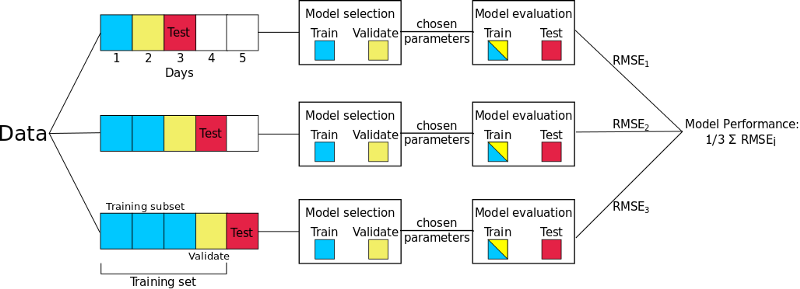
https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

In [39]:
X = np.array(final_cleaned_data.loc[:,["cleaned_text"]])  #getting all preprocessed text values
Y = np.array(final_cleaned_data.loc[:,["Score"]]) #getting all scores values


roc_auc_train_mean = []
roc_auc_cv_mean = []


### TIMESERIES DATA SPLIT

tscv = TimeSeriesSplit(n_splits = 3)      #taking number of split = 3
for train_index,test_index in tscv.split(X):
    x_train , x_test = X[train_index],X[test_index]
    y_train , y_test =  Y[train_index], Y[test_index]
    print(x_train.shape)   
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print("***********************************************************")
    
    ####splitting the x_train data into x_train and x_crossval for finding alpha value.
    x_train , x_cv ,y_train , y_cv = model_selection.train_test_split(x_train,y_train,test_size = 0.3,random_state =42)
    print(x_train.shape)
    print(x_cv.shape)
    print(y_train.shape)
    print(y_cv.shape)
    print("************************************************************")
    
    ### converting the x_train,x_cv into vectors to fit the model.
    x_train_bow = pd.DataFrame(x_train,columns = ["text"])
    x_cv_bow = pd.DataFrame(x_cv,columns = ["text"])
    
    count_vec = CountVectorizer()
    count_vec.fit(x_train_bow["text"].values.astype('U'))
    
    x_train_bow = count_vec.transform(x_train_bow["text"].values.astype('U'))
    x_cv_bow = count_vec.transform(x_cv_bow["text"].values.astype('U'))
    
    ## finding auc score value for each set of train and cross val



    roc_auc_train=[]
    roc_auc_cv = []

    alpha_values = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]   # taking odd values of k.

    for i in alpha_values:
    
        naive_bayes  = MultinomialNB(alpha = i,class_prior=[0.5,0.5] )
        naive_bayes.fit(x_train_bow,y_train.ravel())
    
        y_train_score = naive_bayes.predict_proba(x_train_bow)[:,1]
        y_cv_score = naive_bayes.predict_proba(x_cv_bow)[:,1]          

        roc_auc_train.append(roc_auc_score(y_train,y_train_score))
        roc_auc_cv.append(roc_auc_score(y_cv,y_cv_score)) 
        
    roc_auc_train_mean.append(roc_auc_train)
    roc_auc_cv_mean.append(roc_auc_cv) 
    print(roc_auc_train_mean)
    print("************************************************************")
    print(roc_auc_cv_mean)
    print("###################################################################")





(25000, 1)
(25000, 1)
(25000, 1)
(25000, 1)
***********************************************************
(17500, 1)
(7500, 1)
(17500, 1)
(7500, 1)
************************************************************
[[0.9855078631853974, 0.9845899832063092, 0.9825485020048105, 0.9773768662542429, 0.9654224455350839, 0.9399718499089859, 0.8778370034466088, 0.8349692100533949, 0.8338071020341578]]
************************************************************
[[0.8485958910044543, 0.8671733258482904, 0.8875714330567362, 0.9063197394775847, 0.9173664618503916, 0.9107448166235821, 0.8599223598419817, 0.8231337419410648, 0.8234950629969751]]
###################################################################
(50000, 1)
(50000, 1)
(25000, 1)
(25000, 1)
***********************************************************
(35000, 1)
(15000, 1)
(35000, 1)
(15000, 1)
************************************************************
[[0.9855078631853974, 0.9845899832063092, 0.9825485020048105, 0.9773768662542429, 0.96542

#### OBSERVATION:
1. For each splits auc score is calculated for train and crossval. Now taking mean of the auc value ,alpha having highest auc value of crossval and less difference between crossval and train will be the best hyperparameter. 

In [40]:
## MEAN OF AUC SCORE OF EACH SPLITS.

a = np.array(roc_auc_train_mean)
b = np.array(roc_auc_cv_mean)
print(np.mean(a,axis=0))
print("********************************************")
print(np.mean(b,axis=0))

[0.98037878 0.97935272 0.97712755 0.97199532 0.96095368 0.94387401
 0.91363028 0.88236419 0.83911752]
********************************************
[0.86485035 0.88137451 0.89902263 0.9147682  0.92444355 0.92410343
 0.90373438 0.87750434 0.83504656]


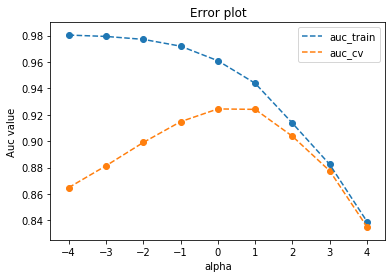

In [41]:
##PLOT BETWEEN AUC AND ALPHA
import math as m

plt.plot(np.log10(alpha_values),np.mean(a,axis=0),label ="auc_train",linestyle ="dashed")
plt.scatter(np.log10(alpha_values),np.mean(a,axis=0))
plt.plot(np.log10(alpha_values),np.mean(b,axis=0),label ="auc_cv",linestyle = "dashed")
plt.scatter(np.log10(alpha_values),np.mean(b,axis=0))
plt.xlabel("alpha")
plt.ylabel("Auc value")
plt.legend()
plt.title("Error plot")
plt.show()


#### OBSERVATION:
The Optimal value of alpha  = 100

##### converting texts into BOW representation.

In [42]:

tscv = TimeSeriesSplit(n_splits = 3)
for train_index,test_index in tscv.split(X):
    x_train , x_test = X[train_index],X[test_index]
    y_train , y_test =  Y[train_index], Y[test_index]
print(x_train.shape,y_train.shape)   

print(x_test.shape,y_test.shape)
  

(75000, 1) (75000, 1)
(25000, 1) (25000, 1)


In [43]:

x_train = pd.DataFrame(x_train,columns = ["text"])    ### making dataframe so that it can fit with countvectorizer.
x_test = pd.DataFrame(x_test,columns = ["text"])


#########################################################################
count_vec = CountVectorizer()
count_vec.fit(x_train["text"].values.astype('U'))


################################################################################

x_train_bow = count_vec.transform(x_train["text"].values.astype('U'))
x_test_bow = count_vec.transform(x_test["text"].values.astype('U'))





##### Fitting with the model and predicting responses.

In [45]:
# INITILAISING THE MODEL.
naive_bayes_bow = MultinomialNB(alpha = 100,class_prior = [0.5,0.5])
naive_bayes_bow.fit(x_train_bow,y_train.ravel())

MultinomialNB(alpha=100, class_prior=[0.5, 0.5], fit_prior=True)

In [46]:
#predicting the responses 
pred_bow = naive_bayes_bow.predict(x_test_bow)

In [47]:
# getting all the features names.
bow_features = count_vec.get_feature_names()
print(bow_features[:20])

['aa', 'aaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaacccccccckkkkkk', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhhyaaaaaa', 'aaaand', 'aaah', 'aaahs', 'aachener', 'aadults', 'aafco', 'aahing', 'aalmost', 'aamazon', 'aamzon', 'aarrgh', 'aauces']


In [48]:
# counting the feature
feature_count_bow = naive_bayes_bow.feature_count_
feature_count_bow.shape

(2, 53526)

In [49]:
#counting class values
naive_bayes_bow.class_count_

array([36738., 38262.])

In [50]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob_bow = naive_bayes_bow.feature_log_prob_
log_prob_bow
print(log_prob_bow.shape)


(2, 53526)


In [51]:
#making dataframe of all features.
feature_prob_bow = pd.DataFrame(log_prob_bow, columns = bow_features)
feature_prob_tr_bow = feature_prob_bow.T
feature_prob_tr_bow.shape
print(feature_prob_tr_bow.head())

                                                      0          1
aa                                           -11.067007 -11.055014
aaa                                          -11.143968 -11.102417
aaaaa                                        -11.134017 -11.122025
aaaaaa                                       -11.143968 -11.122025
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa -11.143968 -11.122025


#### TOP 10 FEATURES FROM  NEGATIVE CLASS

In [52]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr_bow[0].sort_values(ascending = False)[0:10])


Top 10 Negative Features:-
 not       -4.755827
like      -5.864884
would     -6.130005
taste     -6.143181
product   -6.164754
one       -6.339209
good      -6.577954
flavor    -6.606755
no        -6.615895
coffee    -6.631132
Name: 0, dtype: float64


#### TOP 10 FEATURES FROM POSITIVE  CLASS

In [53]:
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr_bow[1].sort_values(ascending = False)[0:10])



 Top 10 Positive Features:-
 not      -5.249963
like     -6.081799
good     -6.222119
great    -6.274258
one      -6.423166
taste    -6.481545
tea      -6.544257
love     -6.598087
flavor   -6.604767
coffee   -6.623096
Name: 1, dtype: float64


##### PERFORMANCE METRICS

In [76]:
pred_bow = naive_bayes_bow.predict(x_test_bow)
#train test accuracy
train_acc_bow = naive_bayes_bow.score(x_train_bow,y_train.ravel())
test_acc_bow = naive_bayes_bow.score(x_test_bow,y_test)

#train test ROC value
y_scores_bow_train = naive_bayes_bow.predict_proba(x_train_bow)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_bow_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_bow = auc(fpr,tpr)

y_scores_bow_test = naive_bayes_bow.predict_proba(x_test_bow)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_bow_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_bow = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_bow = precision_score(y_test, pred_bow) * 100
rec_bow = recall_score(y_test, pred_bow) * 100
f1_bow = f1_score(y_test, pred_bow) * 100


print("\nTrain accuracy=%f%%"% (train_acc_bow*100))
print("\nTest accuracy=%e%% "% (test_acc_bow*100))
print("\nTrain ROC value=%f"% (roc_auc_train_bow))
print("\nTest ROC value=%f"% (roc_auc_test_bow))
print('\nprecision=%f%%' % (pre_bow))
print('\nrecall=%f%%' % (rec_bow))
print('\nF1-Score=%f%%' % (f1_bow))




Train accuracy=86.588000%

Test accuracy=8.548800e+01% 

Train ROC value=0.933239

Test ROC value=0.923248

precision=88.937968%

recall=78.906117%

F1-Score=83.622246%


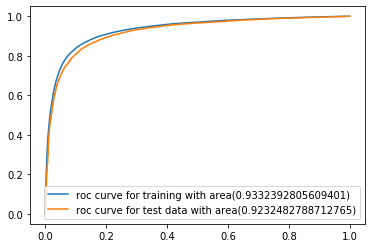

In [77]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc_train_bow))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_bow))
plt.legend(loc="lower right")
plt.show()

In [78]:
 #Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_test, pred_bow)
cm_bow

array([[12110,  1152],
       [ 2476,  9262]], dtype=int64)

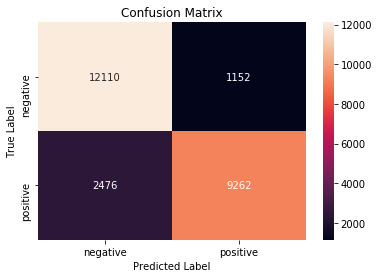

In [79]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [142]:
from prettytable import PrettyTable
x = PrettyTable()

alpha_bow = 100
cv = 'double chain method'
x.field_names = ["CV","alpha_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR","AUC_train","AUC_test"]


err_train_bow = np.around(100 - train_acc_bow*100 , decimals = 2)
err_test_bow =  np.around(100 - test_acc_bow*100 , decimals = 2)
pre_bow= np.around(pre_bow, decimals = 2)
rec_bow = np.around(rec_bow, decimals = 2)
f1_bow = np.around(f1_bow, decimals = 2)
AUC_train_bow = np.around(roc_auc_train_bow,decimals=2)
AUC_test_bow = np.around(roc_auc_test_bow,decimals=2)
TPR = 9262
TNR = 12110
FPR = 2476
FNR = 1152


x.add_row([cv,alpha_bow,err_train_bow,err_test_bow,pre_bow,rec_bow,f1_bow,TPR,TNR,FPR,FNR,AUC_train_bow,AUC_test_bow])


print(x)

+---------------------+-------------+----------------+---------------+--------------+-----------+-------------+------+-------+------+------+-----------+----------+
|          CV         | alpha_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | TPR  |  TNR  | FPR  | FNR  | AUC_train | AUC_test |
+---------------------+-------------+----------------+---------------+--------------+-----------+-------------+------+-------+------+------+-----------+----------+
| double chain method |     100     |     13.41      |     14.51     |    88.94     |   78.91   |    83.62    | 9262 | 12110 | 2476 | 1152 |    0.93   |   0.92   |
+---------------------+-------------+----------------+---------------+--------------+-----------+-------------+------+-------+------+------+-----------+----------+


#### OBSERVATION:
The f_1 score value for positive and negative reviews are 0.85 and 0.87 respectively..

##  Applying Naive Bayes on TFIDF

### HYPERPARAMETER TUNING:<font color="red"> CROSS VALIDATION

The amazon food fine reviews is a time series data. Considering the variations in future data, we should find hyperparameter in such a way that the performance of model would not get affected much by different reviews.

#### NOTE:
For above purpose we will do time series split of data and find the hyperparameter using nested crossvalidation: Day-Forward Chaining method.
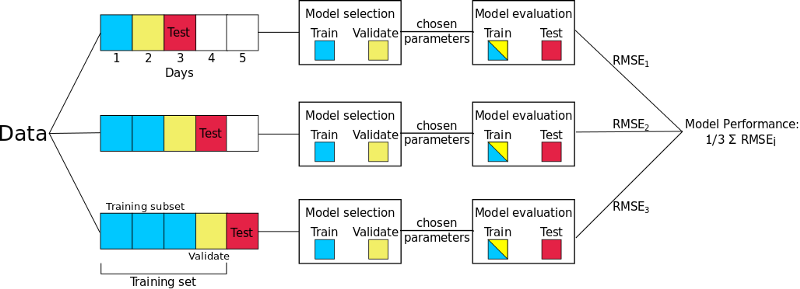

In [84]:
X = np.array(final_cleaned_data.loc[:,["cleaned_text"]])  #getting all preprocessed text values
Y = np.array(final_cleaned_data.loc[:,["Score"]]) #getting all scores values

roc_auc_train_mean = []
roc_auc_cv_mean = []

##TIMESERIES DATA SPLIT
tscv = TimeSeriesSplit(n_splits = 3)
for train_index,test_index in tscv.split(X):
    x_train , x_test = X[train_index],X[test_index]
    y_train , y_test =  Y[train_index], Y[test_index]
    print(x_train.shape)   
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print("***********************************************************")
    
    ####splitting the x_train data into x_train and x_crossval for finding alpha value
    x_train , x_cv ,y_train , y_cv = model_selection.train_test_split(x_train,y_train,test_size = 0.3,random_state =42)
    print(x_train.shape)
    print(x_cv.shape)
    print(y_train.shape)
    print(y_cv.shape)
    print("************************************************************")
    
    ### converting the x_train,x_cv into vectors to fit the model.
    x_train_tfidf = pd.DataFrame(x_train,columns = ["text"])
    x_cv_tfidf = pd.DataFrame(x_cv,columns = ["text"])
    
    tfidf_vec = TfidfVectorizer()
    tfidf_vec.fit(x_train_tfidf["text"].values.astype('U'))
    
    x_train_tfidf = tfidf_vec.transform(x_train_tfidf["text"].values.astype('U'))
    x_cv_tfidf = tfidf_vec.transform(x_cv_tfidf["text"].values.astype('U'))
    
    ## finding auc score value for each set of train and cross val



    roc_auc_train=[]
    roc_auc_cv = []

    alpha_values = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]   # taking odd values of k.

    for i in alpha_values:
    
        naive_bayes  = MultinomialNB(alpha = i,class_prior=[0.5,0.5] )
        naive_bayes.fit(x_train_tfidf,y_train.ravel())
    
        y_train_score = naive_bayes.predict_proba(x_train_tfidf)[:,1]
        y_cv_score = naive_bayes.predict_proba(x_cv_tfidf)[:,1]          

        roc_auc_train.append(roc_auc_score(y_train,y_train_score))
        roc_auc_cv.append(roc_auc_score(y_cv,y_cv_score)) 
        
    roc_auc_train_mean.append(roc_auc_train)
    roc_auc_cv_mean.append(roc_auc_cv) 
    print(roc_auc_train_mean)
    print("************************************************************")
    print(roc_auc_cv_mean)
    print("###################################################################")





(25000, 1)
(25000, 1)
(25000, 1)
(25000, 1)
***********************************************************
(17500, 1)
(7500, 1)
(17500, 1)
(7500, 1)
************************************************************
[[0.9908525491619686, 0.9903068169756922, 0.9887786039330431, 0.9834304658992566, 0.9685014602268789, 0.939826589745128, 0.9062499048514211, 0.8897629997797629, 0.8871014836981972]]
************************************************************
[[0.8396716307282855, 0.8642303683857779, 0.8932902832190045, 0.9198314647192793, 0.9322483501810847, 0.9215112487010606, 0.8965761802628791, 0.8819100114066657, 0.8792786688824984]]
###################################################################
(50000, 1)
(50000, 1)
(25000, 1)
(25000, 1)
***********************************************************
(35000, 1)
(15000, 1)
(35000, 1)
(15000, 1)
************************************************************
[[0.9908525491619686, 0.9903068169756922, 0.9887786039330431, 0.9834304658992566, 0.968501

In [85]:
#MEAN OF AUC SCORES

a = np.array(roc_auc_train_mean)
b = np.array(roc_auc_cv_mean)
print(np.mean(a,axis=0))
print("********************************************")
print(np.mean(b,axis=0))

[0.98595964 0.98529337 0.98347984 0.97786634 0.96492636 0.94693165
 0.92630718 0.91069425 0.90375413]
********************************************
[0.85384564 0.87597438 0.90205114 0.925151   0.93669143 0.93422168
 0.92101234 0.90752005 0.90063608]


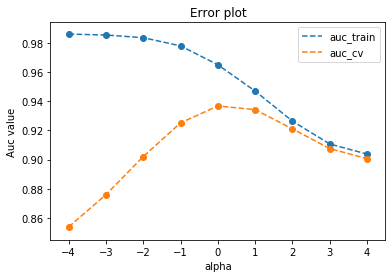

In [86]:
# GRAPH

plt.plot(np.log10(alpha_values),np.mean(a,axis=0),label ="auc_train",linestyle = "dashed")
plt.scatter(np.log10(alpha_values),np.mean(a,axis=0))
plt.plot(np.log10(alpha_values),np.mean(b,axis=0),label ="auc_cv",linestyle = "dashed")
plt.scatter(np.log10(alpha_values),np.mean(b,axis=0))
plt.xlabel("alpha")
plt.ylabel("Auc value")
plt.legend()
plt.title("Error plot")
plt.show()

#### OBSERVATION:
The optimal value of alpha = 100

##### Converting text reviews into TFIDF vector representation

In [87]:
X = np.array(final_cleaned_data.loc[:,["cleaned_text"]])  #getting all preprocessed text values
Y = np.array(final_cleaned_data.loc[:,["Score"]]) #getting all scores values

tscv = TimeSeriesSplit(n_splits = 3)
for train_index,test_index in tscv.split(X):
    x_train , x_test = X[train_index],X[test_index]
    y_train , y_test =  Y[train_index], Y[test_index]
print(x_train.shape,y_train.shape)   

print(x_test.shape,y_test.shape)
  

(75000, 1) (75000, 1)
(25000, 1) (25000, 1)


In [88]:
#converting train,cross validation , and test data into vectors using BOW representation

x_train = pd.DataFrame(x_train,columns = ["text"])
x_test = pd.DataFrame(x_test,columns = ["text"])


#########################################################################
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(x_train["text"].values.astype('U'))


################################################################################

x_train_tfidf = tf_idf_vect.transform(x_train["text"].values.astype('U'))
x_test_tfidf= tf_idf_vect.transform(x_test["text"].values.astype('U'))



##### Fitting the model and predicting responses

In [89]:
#INITIALISING THE MODEL
naive_bayes_tfidf = MultinomialNB(alpha = 100,class_prior = [0.5,0.5])
naive_bayes_tfidf.fit(x_train_tfidf,y_train.ravel())

MultinomialNB(alpha=100, class_prior=[0.5, 0.5], fit_prior=True)

In [90]:
#predicting the responses 
pred_tfidf = naive_bayes_tfidf.predict(x_test_tfidf)

In [91]:
# getting all the features names
tfidf_features = tf_idf_vect.get_feature_names()
print(tfidf_features[:20])

['aa', 'aaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaacccccccckkkkkk', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhhyaaaaaa', 'aaaand', 'aaah', 'aaahs', 'aachener', 'aadults', 'aafco', 'aahing', 'aalmost', 'aamazon', 'aamzon', 'aarrgh', 'aauces']


In [92]:
#counting the feature
feature_count_tfidf = naive_bayes_tfidf.feature_count_
feature_count_tfidf.shape

(2, 53526)

In [93]:
#counting class labels 
naive_bayes_tfidf.class_count_

array([36738., 38262.])

In [94]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob_tfidf = naive_bayes_tfidf.feature_log_prob_
log_prob_tfidf
print(log_prob_tfidf.shape)


(2, 53526)


In [95]:
#making dataframe of features
feature_prob_tfidf = pd.DataFrame(log_prob_tfidf, columns = tfidf_features)
feature_prob_tr_tfidf = feature_prob_tfidf.T
feature_prob_tr_tfidf.shape
print(feature_prob_tr_tfidf.head())

                                                      0          1
aa                                           -10.905474 -10.908001
aaa                                          -10.921449 -10.911786
aaaaa                                        -10.917878 -10.917637
aaaaaa                                       -10.921449 -10.919031
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa -10.921449 -10.917350


### TOP 10 FEATURES FROM  NEGATIVE REVIEWS.

In [96]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr_tfidf[0].sort_values(ascending = False)[0:10])


Top 10 Negative Features:-
 not       -7.749032
like      -8.447347
taste     -8.537495
product   -8.580349
would     -8.607524
coffee    -8.759498
one       -8.813910
flavor    -8.892130
no        -8.949391
good      -8.952714
Name: 0, dtype: float64


### TOP 10 FEATURES FROM  POSITIVE REVIEWS.

In [97]:
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr_tfidf[1].sort_values(ascending = False)[0:10])



 Top 10 Positive Features:-
 not      -8.270060
great    -8.388509
good     -8.532281
love     -8.630207
tea      -8.644219
like     -8.652560
coffee   -8.661916
taste    -8.851681
flavor   -8.851939
one      -8.852102
Name: 1, dtype: float64


##### PERFORMANCE METRICS

In [98]:
pred_tfidf = naive_bayes_tfidf.predict(x_test_tfidf)
#train test accuracy
train_acc_tfidf = naive_bayes_tfidf.score(x_train_tfidf,y_train.ravel())
test_acc_tfidf = naive_bayes_tfidf.score(x_test_tfidf,y_test)

#train test ROC value
y_scores_tfidf_train = naive_bayes_tfidf.predict_proba(x_train_tfidf)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_tfidf_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_tfidf = auc(fpr,tpr)

y_scores_tfidf_test = naive_bayes_tfidf.predict_proba(x_test_tfidf)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_tfidf_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_tfidf = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_tfidf = precision_score(y_test, pred_tfidf) * 100
rec_tfidf = recall_score(y_test, pred_tfidf) * 100
f1_tfidf = f1_score(y_test, pred_tfidf) * 100


print("\nTrain accuracy=%f%%"% (train_acc_tfidf*100))
print("\nTest accuracy=%e%% "% (test_acc_tfidf*100))
print("\nTrain ROC value=%f"% (roc_auc_train_tfidf))
print("\nTest ROC value=%f"% (roc_auc_test_tfidf))
print('\nprecision=%f%%' % (pre_tfidf))
print('\nrecall=%f%%' % (rec_tfidf))
print('\nF1-Score=%f%%' % (f1_tfidf))




Train accuracy=86.306667%

Test accuracy=8.517600e+01% 

Train ROC value=0.940779

Test ROC value=0.933432

precision=81.478288%

recall=88.558528%

F1-Score=84.870999%


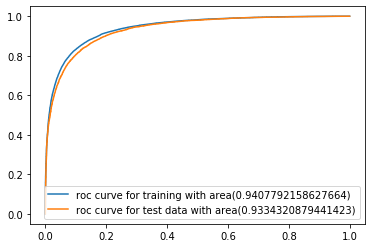

In [99]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc_train_tfidf))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_tfidf))
plt.legend(loc="lower right")
plt.show()

In [100]:
 #Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_tfidf = confusion_matrix(y_test, pred_tfidf)
cm_tfidf

array([[10899,  2363],
       [ 1343, 10395]], dtype=int64)

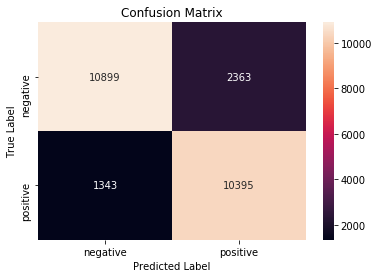

In [101]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [144]:
from prettytable import PrettyTable
x = PrettyTable()

alpha_tfidf = 100
cv = 'double chain method'
x.field_names = ["CV","alpha_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR","AUC_train","AUC_test"]


err_train_tfidf = np.around(100 - train_acc_tfidf*100 , decimals = 2)
err_test_tfidf =  np.around(100 - test_acc_tfidf*100 , decimals = 2)
pre_tfidf= np.around(pre_tfidf, decimals = 2)
rec_tfidf = np.around(rec_tfidf, decimals = 2)
f1_tfidf = np.around(f1_tfidf, decimals = 2)
AUC_train_tfidf = np.around(roc_auc_train_tfidf,decimals=2)
AUC_test_tfidf = np.around(roc_auc_test_tfidf,decimals=2)
TPR = 10395
TNR = 10899
FPR = 1343
FNR = 2363


x.add_row([cv,alpha_tfidf,err_train_tfidf,err_test_tfidf,pre_tfidf,rec_tfidf,f1_tfidf,TPR,TNR,FPR,FNR,AUC_train_tfidf,AUC_test_tfidf])


print(x)

+---------------------+-------------+----------------+---------------+--------------+-----------+-------------+-------+-------+------+------+-----------+----------+
|          CV         | alpha_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) |  TPR  |  TNR  | FPR  | FNR  | AUC_train | AUC_test |
+---------------------+-------------+----------------+---------------+--------------+-----------+-------------+-------+-------+------+------+-----------+----------+
| double chain method |     100     |     13.69      |     14.82     |    81.48     |   88.56   |    84.87    | 10395 | 10899 | 1343 | 2363 |    0.94   |   0.93   |
+---------------------+-------------+----------------+---------------+--------------+-----------+-------------+-------+-------+------+------+-----------+----------+


#### OBSERVATION:
The f_1 score of postive and negative reviews are 0.85  and 0.86 respectively.

# Performance Table

In [145]:
from prettytable import PrettyTable
x = PrettyTable()


model1 = "BOW"
model2 ="TFIDF"

x.field_names = ["model","alpha_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","AUC_train","AUC_test"]
x.add_row([model1,alpha_bow,err_train_bow,err_test_bow,pre_bow,rec_bow,f1_bow,AUC_train_bow,AUC_test_bow])
x.add_row([model2,alpha_tfidf,err_train_tfidf,err_test_tfidf,pre_tfidf,rec_tfidf,f1_tfidf,AUC_train_tfidf,AUC_test_tfidf])


print(x)

+-------+-------------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
| model | alpha_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | AUC_train | AUC_test |
+-------+-------------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
|  BOW  |     100     |     13.41      |     14.51     |    88.94     |   78.91   |    83.62    |    0.93   |   0.92   |
| TFIDF |     100     |     13.69      |     14.82     |    81.48     |   88.56   |    84.87    |    0.94   |   0.93   |
+-------+-------------+----------------+---------------+--------------+-----------+-------------+-----------+----------+


## CONCLUSION:
1.The AUC value for both train and test data are high which implies Naive Bayes algorithm is working well for text classification.<br>
2.From all the performance metrics, it can be concluded that naive bayes model can do good text classification, that's why it's widely used in real world cases like spam filtering.<br>
3.Comparing AUC value of both models tfidf  works slightly good than bow, not much difference, both are working fine.

### <font color = "BLUE"> CONSIDERING LENGTH OF REVIEWS AS A FEATURE TO TRAIN OUR MODEL.

In [105]:
final.shape

(364171, 11)

In [106]:
#Creating a list of lengths of all reviews
length_of_reviews = []
for i in preprocessed_reviews:
    length_of_reviews.append(len(i))
print(len(length_of_reviews))    

364171


In [107]:
print(length_of_reviews[:10])

[222, 173, 98, 309, 230, 210, 302, 114, 99, 69]


In [108]:
# adding length of reviews in amazon food fine reviews dataset
final["length_of_reviews"] = length_of_reviews

In [109]:
final.shape


(364171, 12)

In [110]:
#Randomly taking 50000 points from each positive and negative reviews due to less memory capacity
data_pos_length = final[final["Score"] ==1.0].sample(n = 50000)
data_neg_length= final[final["Score"] ==0.0].sample(n = 50000)


#concatenating the positive and negative reviews data 
final_length_data= pd.concat([data_pos_length,data_neg_length],axis=0)

print(final_length_data.shape)
final_length_data.head()

(100000, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,length_of_reviews
222509,241289,B001W9L2GE,A2AUA0LHP10Z7O,Jared Mevissen,1,1,1,1282694400,Awesome stuff but price may be a bit high,This stuff is awesome however the price may be...,stuff awesome however price may bit high howev...,276
8875,9719,B001LXYA5Q,A1L00F5RGURLCU,Jamie,0,0,1,1261440000,Miracle? No. Fun? Absolutely!,Bought some of these after getting frustrated ...,bought getting frustrated not able grow plant ...,765
313968,339946,B001FA1DKA,A37GGAULI13P7Y,"John C. Nielsen ""John Nielsen""",6,6,1,1271894400,Great Macadamia Nuts,I ordered these after the ones I bought in Haw...,ordered ones bought hawaii gone fresh ones bou...,96
339577,367403,B0051CDE3W,A2YN5NM1O1HFZV,Shanat Lopez,1,1,1,1345334400,I think it's a biased opinion,Being of Mexican descent I grew up around Mexi...,mexican descent grew around mexican candy wier...,461
221477,240089,B001VJ0B0I,A3SMD3T0QTN109,Dustin,0,0,1,1350518400,A good normal dog food,"For the money, this is an OK dog food in many ...",money ok dog food many respects first package ...,98


#### NOTE:
1.The length of review is a Numerical feature. So, To deal with, we consider that the length of reviews are normally
distributed.<br>
2.We will plot pdf for both positive and negative reviews. Then, we will  calculate the probability for each query point of both classes using pdf.   


#### PDF FOR POSITIVE REVIEWS.

counts are [1.52128592e-03 8.68322780e-05 1.15927910e-05 2.79266115e-06
 5.19564864e-07 1.94836824e-07 2.27309628e-07 3.24728040e-08
 6.49456081e-08 9.74184121e-08]
***********************************************************
bin_edges are [   0.   615.9 1231.8 1847.7 2463.6 3079.5 3695.4 4311.3 4927.2 5543.1
 6159. ]
***********************************************************


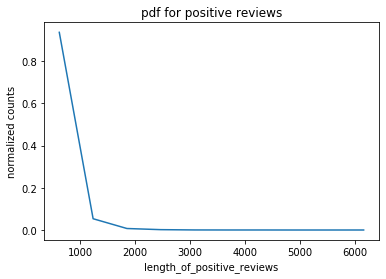

In [111]:
counts,bin_edges = np.histogram(data_pos_length["length_of_reviews"],bins=10,density=True)
pdf = counts/counts.sum()
cdf = np.cumsum(pdf)
print("counts are",counts)
print("***********************************************************")
print("bin_edges are",bin_edges)
print("***********************************************************")

plt.plot(bin_edges[1:],pdf)
#plt.plot(bin_edges[1:],cdf)
plt.ylabel("normalized counts")
plt.xlabel("length_of_positive_reviews")
plt.title("pdf for positive reviews")
plt.show()

#### PDF FOR NEGATIVE REVIEWS

counts are [1.36098830e-03 7.10879931e-05 9.50729663e-06 1.96503395e-06
 7.51336512e-07 2.60078023e-07 1.15590233e-07 8.66926745e-08
 5.77951163e-08 5.77951163e-08]
***********************************************************
bin_edges are [   0.   692.1 1384.2 2076.3 2768.4 3460.5 4152.6 4844.7 5536.8 6228.9
 6921. ]
***********************************************************


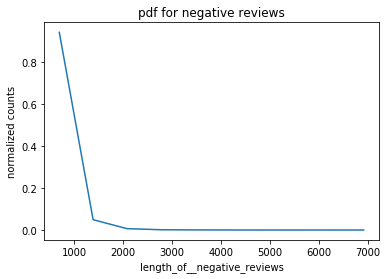

In [112]:
counts,bin_edges = np.histogram(data_neg_length["length_of_reviews"],bins=10,density=True)
pdf = counts/counts.sum()
cdf = np.cumsum(pdf)
print("counts are",counts)
print("***********************************************************")
print("bin_edges are",bin_edges)
print("***********************************************************")

plt.plot(bin_edges[1:],pdf)
#plt.plot(bin_edges[1:],cdf)
plt.ylabel("normalized counts")
plt.xlabel("length_of__negative_reviews")
plt.title("pdf for negative reviews")
plt.show()

### OBSERVATION: 
1.The pdf of both the classes are not distributed normally.<br>
2.It seems that positive and negative reviews are having power law distribution.

### CONCLUSION:
1. Using length of reviews as a feature is not so helpful because these are not following any of these distribiutions-normal, binomial, and poisson's. It's difficult and lengthy to train a probablistic model which is not following above mentioned distributions.<br>
2. There can be another method to calculate probablities- using power law transformation which transform power law distribution to normal distribution. But it's our assumption that above pdf is following power law distribution. Using it simply will not give a well working model as we are fully relying on assumptions.

### <font color = "blue"> CONSIDERING SUMMARY AS ANOTHER FEATURE FOR MODEL TRAINING.

In [113]:
### APPLYING ALL THE SAME METHODS AS DONE FOR TEXT REVIEWS.

In [114]:
print(final.shape)
print("*************************************************")

##adding cleaned_text column to the final dataframe
final["cleaned_summary"] = preprocessed_reviews_summary

print(final.shape)
print("*************************************************************************************")
#checking if any missing values is present in the reviews.
final = final.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

print(final.shape)

final.head()

(364171, 12)
*************************************************
(364171, 13)
*************************************************************************************
(364171, 13)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,length_of_reviews,cleaned_summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,222,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,173,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,98,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,309,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,230,great way learn months


In [115]:
#Randomly taking 40000 points from each positive and negative reviews due to less memory capacity
data_pos_summ = final[final["Score"] ==1.0].sample(n = 50000)
data_neg_summ = final[final["Score"] ==0.0].sample(n = 50000)


#concatenating the positive and negative reviews data 
final_cleaned_summ_data = pd.concat([data_pos_summ,data_neg_summ],axis=0)

print(final_cleaned_summ_data.shape)
final_cleaned_summ_data.head()

(100000, 13)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,length_of_reviews,cleaned_summary
175380,190200,B004APZYVG,A3DBXS2APREN5C,Tink,0,0,1,1339891200,Yum!,I love Cafe Escapes Cafe Mocha but it seems to...,love cafe escapes cafe mocha seems sell stores...,258,yum
22251,24355,B003VMY4KG,AX3T5TI76TOJ1,"TurquoiseEyes13579 ""Author of &#34;The Organi...",0,0,1,1338595200,"Full of vitamins & minerals, made with ingredi...","I'm allergic to soy protein, and it breaks me ...",allergic soy protein breaks terribly glad find...,711,full vitamins minerals made ingredients actual...
159358,172761,B000FVZW8E,A331T1MEPUCBYV,"Suzanna Davis ""suzanna""",0,0,1,1185408000,Good enough to snack on without a topping,"Good with peanut butter, good alone. Not too ...",good peanut butter good alone not sweet defini...,64,good enough snack without topping
280291,303702,B000E65OJW,AK5LUYO0MMBVV,T. Blankenbaker,0,0,1,1191888000,Doesn't taste herbal,"This tea is herbal, but tastes like a smooth r...",tea herbal tastes like smooth regular tea make...,243,not taste herbal
108168,117416,B001AVK422,A2C7VMQESBQZN4,B. Devine,6,6,1,1243987200,great farro resotto,Made this risotto with farro rather than rice ...,made risotto farro rather rice using standard ...,167,great farro resotto


#### Note:
Time based splitting of the reviews.

In [116]:
#time based splitting of the data
#converting time to date and time
final_cleaned_summ_data["Time"] = pd.to_datetime(final_cleaned_summ_data["Time"],unit="s")
final_cleaned_summ_data = final_cleaned_summ_data.sort_values(by = "Time")
final_cleaned_summ_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,length_of_reviews,cleaned_summary
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,101,entertainingl funny
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,171,fantastic
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,getting crazy looking beatlejuice french versi...,145,research beatlejuice video french version
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...,109,great product
138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,2000-08-09,Very easy to use,This are so much easier to use than the Wilson...,much easier use wilson paste colors colors vib...,155,easy use


### HYPERPARAMETER TUNING:<font color = "red"> CROSS VALIDATION

The amazon food fine reviews is a time series data. Considering the variations in future data, we should find hyperparameter in such a way that the performance of model would not get affected much by different reviews.

#### NOTE:
For above purpose we will do time series split of data and find the hyperparameter using nested crossvalidation: Day-Forward Chaining method.
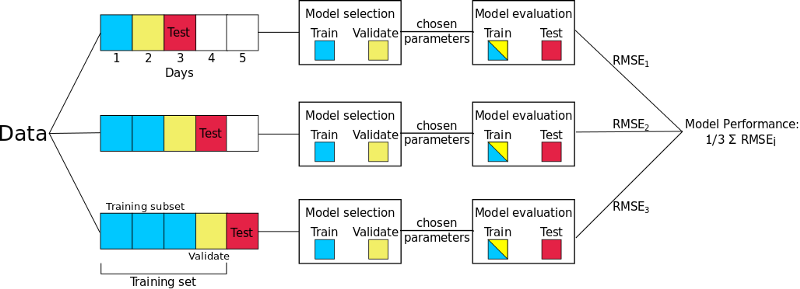

In [118]:

X = np.array(final_cleaned_summ_data.loc[:,["cleaned_summary"]])  #getting all preprocessed text values
Y = np.array(final_cleaned_summ_data.loc[:,["Score"]]) #getting all scores values
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

roc_auc_train_mean = []
roc_auc_cv_mean = []
## USING TIMESERIES DATA SPLIT
tscv = TimeSeriesSplit(n_splits = 3)
for train_index,test_index in tscv.split(X):
    x_train , x_test = X[train_index],X[test_index]
    y_train , y_test =  Y[train_index], Y[test_index]
    print(x_train.shape)   
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print("***********************************************************")
    
    ####splitting the x_train data into x_train and x_crossval for finding alpha value
    x_train , x_cv ,y_train , y_cv = model_selection.train_test_split(x_train,y_train,test_size = 0.3,random_state =42)
    print(x_train.shape)
    print(x_cv.shape)
    print(y_train.shape)
    print(y_cv.shape)
    print("************************************************************")
    
    ### converting the x_train,x_cv into vectors to fit the model.
    x_train_tfidf = pd.DataFrame(x_train,columns = ["text"])
    x_cv_tfidf = pd.DataFrame(x_cv,columns = ["text"])
    
    tfidf_vec = TfidfVectorizer()
    tfidf_vec.fit(x_train_tfidf["text"].values.astype('U'))
    
    x_train_tfidf = tfidf_vec.transform(x_train_tfidf["text"].values.astype('U'))
    x_cv_tfidf = tfidf_vec.transform(x_cv_tfidf["text"].values.astype('U'))
    
    ## finding auc score value for each set of train and cross val



    roc_auc_train=[]
    roc_auc_cv = []

    alpha_values = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]   # taking odd values of k.

    for i in alpha_values:
    
        naive_bayes  = MultinomialNB(alpha = i,class_prior=[0.5,0.5] )
        naive_bayes.fit(x_train_tfidf,y_train.ravel())
    
        y_train_score = naive_bayes.predict_proba(x_train_tfidf)[:,1]
        y_cv_score = naive_bayes.predict_proba(x_cv_tfidf)[:,1]          

        roc_auc_train.append(roc_auc_score(y_train,y_train_score))
        roc_auc_cv.append(roc_auc_score(y_cv,y_cv_score)) 
        
    roc_auc_train_mean.append(roc_auc_train)
    roc_auc_cv_mean.append(roc_auc_cv) 
    print(roc_auc_train_mean)
    print("************************************************************")
    print(roc_auc_cv_mean)
    print("###################################################################")





(25000, 1)
(25000, 1)
(25000, 1)
(25000, 1)
***********************************************************
(17500, 1)
(7500, 1)
(17500, 1)
(7500, 1)
************************************************************
[[0.9738341977370579, 0.9737825167558389, 0.9734108214883868, 0.9707360708394595, 0.9572933118906569, 0.9313360393217904, 0.905048384286343, 0.8917883878379111, 0.8890906486143054]]
************************************************************
[[0.8583139786660772, 0.8632182804213151, 0.8753223372006429, 0.8970833008691934, 0.9134097131498793, 0.9112771906046665, 0.8976244222138067, 0.8863408172990682, 0.8840117342011375]]
###################################################################
(50000, 1)
(50000, 1)
(25000, 1)
(25000, 1)
***********************************************************
(35000, 1)
(15000, 1)
(35000, 1)
(15000, 1)
************************************************************
[[0.9738341977370579, 0.9737825167558389, 0.9734108214883868, 0.9707360708394595, 0.957293

In [119]:
#FINDING MEAN
a = np.array(roc_auc_train_mean)
b = np.array(roc_auc_cv_mean)
print(np.mean(a,axis=0))
print("********************************************")
print(np.mean(b,axis=0))

[0.96839713 0.96834418 0.96799203 0.965619   0.9545888  0.93438366
 0.91237562 0.89653441 0.8919544 ]
********************************************
[0.87064568 0.87489905 0.88532431 0.90384558 0.91823626 0.91758698
 0.90485656 0.8901221  0.88577122]


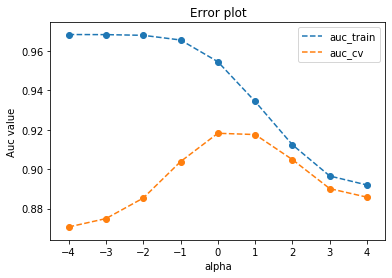

In [120]:
#GRAPH

plt.plot(np.log10(alpha_values),np.mean(a,axis=0),label ="auc_train",linestyle = "dashed")
plt.scatter(np.log10(alpha_values),np.mean(a,axis=0))
plt.plot(np.log10(alpha_values),np.mean(b,axis=0),label ="auc_cv",linestyle = "dashed")
plt.scatter(np.log10(alpha_values),np.mean(b,axis=0))
plt.xlabel("alpha")
plt.ylabel("Auc value")
plt.legend()
plt.title("Error plot")
plt.show()

#### OBSERVATION:
The optimal value of alpha is 100

##### CONVERTING SUMMARY  INTO TFIDF VECTOR REPRESENTATION

In [121]:
tscv = TimeSeriesSplit(n_splits = 3)
for train_index,test_index in tscv.split(X):
    x_train , x_test = X[train_index],X[test_index]
    y_train , y_test =  Y[train_index], Y[test_index]
print(x_train.shape,y_train.shape)   

print(x_test.shape,y_test.shape)
  

(75000, 1) (75000, 1)
(25000, 1) (25000, 1)


In [122]:
#converting train,cross validation , and test data into vectors using BOW representation

x_train_summ = pd.DataFrame(x_train,columns = ["text"])
x_test_summ = pd.DataFrame(x_test,columns = ["text"])


#########################################################################
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(x_train_summ["text"].values.astype('U'))


################################################################################

x_train_summ_tfidf = tfidf_vec.transform(x_train_summ["text"].values.astype('U'))
x_test_summ_tfidf = tfidf_vec.transform(x_test_summ["text"].values.astype('U'))



##### TRAINING THE MODEL AND PREDICTING LABELS

In [123]:
naive_bayes_summ_tfidf = MultinomialNB(alpha = 100,class_prior=[0.5,0.5])
naive_bayes_summ_tfidf.fit(x_train_summ_tfidf,y_train.ravel())

MultinomialNB(alpha=100, class_prior=[0.5, 0.5], fit_prior=True)

In [124]:
#predicting the responses 
pred_summ_tfidf = naive_bayes_summ_tfidf.predict(x_test_summ_tfidf)

In [125]:
#all the features names
tfidf_summ_features = tfidf_vec.get_feature_names()
print(tfidf_summ_features[:20])

['aa', 'aaa', 'aaaamaaaazing', 'aaaarrrrrgggghhhhh', 'aaah', 'aachener', 'aack', 'abalone', 'abbey', 'abc', 'abdominal', 'abi', 'abide', 'able', 'aboard', 'abomination', 'abominations', 'abounds', 'absence', 'absent']


In [126]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob_summ_tfidf = naive_bayes_summ_tfidf.feature_log_prob_
log_prob_summ_tfidf
print(log_prob_summ_tfidf.shape)


(2, 14406)


In [127]:
#making dataframes of features
feature_prob_summ_tfidf = pd.DataFrame(log_prob_summ_tfidf, columns = tfidf_summ_features)
feature_prob_tr_summ_tfidf = feature_prob_summ_tfidf.T
feature_prob_tr_summ_tfidf.shape
print(feature_prob_tr_summ_tfidf.head())

                           0         1
aa                 -9.615497 -9.610909
aaa                -9.615497 -9.606895
aaaamaaaazing      -9.615497 -9.606895
aaaarrrrrgggghhhhh -9.605547 -9.616846
aaah               -9.615497 -9.609085


In [128]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr_summ_tfidf[0].sort_values(ascending = False)[0:10])


Top 10 Negative Features:-
 not            -6.252615
good           -7.492265
taste          -7.504498
disappointed   -7.634702
like           -7.691616
bad            -7.833870
product        -7.958295
yuck           -7.996274
terrible       -8.002590
no             -8.011094
Name: 0, dtype: float64


In [129]:
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr_summ_tfidf[1].sort_values(ascending = False)[0:10])



 Top 10 Positive Features:-
 great       -6.433286
good        -6.809007
best        -7.029609
love        -7.083469
delicious   -7.182198
product     -7.460232
coffee      -7.492856
tea         -7.508825
yummy       -7.578449
excellent   -7.595957
Name: 1, dtype: float64


##### PERFORMANCE METRICS

In [132]:
pred_summ_tfidf = naive_bayes_summ_tfidf.predict(x_test_summ_tfidf)
#train test accuracy
train_acc_summ_tfidf = naive_bayes_summ_tfidf.score(x_train_summ_tfidf,y_train.ravel())
test_acc_summ_tfidf = naive_bayes_summ_tfidf.score(x_test_summ_tfidf,y_test)

#train test ROC value
y_scores_summ_tfidf_train = naive_bayes_summ_tfidf.predict_proba(x_train_summ_tfidf)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_summ_tfidf_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_summ_tfidf = auc(fpr,tpr)

y_scores_summ_tfidf_test = naive_bayes_summ_tfidf.predict_proba(x_test_summ_tfidf)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_summ_tfidf_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_summ_tfidf = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_summ_tfidf = precision_score(y_test, pred_summ_tfidf) * 100
rec_summ_tfidf = recall_score(y_test, pred_summ_tfidf) * 100
f1_summ_tfidf = f1_score(y_test, pred_summ_tfidf) * 100


print("\nTrain accuracy=%f%%"% (train_acc_summ_tfidf*100))
print("\nTest accuracy=%e%% "% (test_acc_summ_tfidf*100))
print("\nTrain ROC value=%f"% (roc_auc_train_summ_tfidf))
print("\nTest ROC value=%f"% (roc_auc_test_summ_tfidf))
print('\nprecision=%f%%' % (pre_summ_tfidf))
print('\nrecall=%f%%' % (rec_summ_tfidf))
print('\nF1-Score=%f%%' % (f1_summ_tfidf))




Train accuracy=85.164000%

Test accuracy=8.360800e+01% 

Train ROC value=0.919191

Test ROC value=0.913697

precision=81.243440%

recall=85.004646%

F1-Score=83.081496%


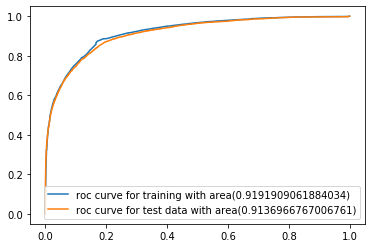

In [134]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc_train_summ_tfidf))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_summ_tfidf))
plt.legend(loc="lower right")
plt.show()

In [135]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_summ_tfidf = confusion_matrix(y_test, pred_summ_tfidf)
cm_summ_tfidf

array([[10840,  2323],
       [ 1775, 10062]], dtype=int64)

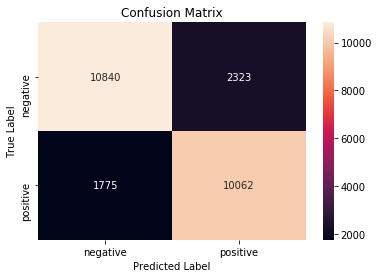

In [136]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_summ_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [146]:
from prettytable import PrettyTable
x = PrettyTable()

alpha_summ_tfidf = 100
cv = 'double chain method'
x.field_names = ["CV","alpha_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR"]


err_train_summ_tfidf = np.around(100 - train_acc_summ_tfidf*100 , decimals = 2)
err_test_summ_tfidf =  np.around(100 - test_acc_summ_tfidf*100 , decimals = 2)
pre_summ_tfidf= np.around(pre_summ_tfidf, decimals = 2)
rec_summ_tfidf = np.around(rec_summ_tfidf, decimals = 2)
f1_summ_tfidf = np.around(f1_summ_tfidf, decimals = 2)
AUC_train_summ_tfidf = np.around(roc_auc_train_summ_tfidf,decimals=2)
AUC_test_summ_tfidf = np.around(roc_auc_test_summ_tfidf,decimals=2)
TPR = 10062
TNR = 108840
FPR = 1775
FNR = 2323


x.add_row([cv,alpha_summ_tfidf,err_train_summ_tfidf,err_test_summ_tfidf,pre_summ_tfidf,rec_summ_tfidf,f1_summ_tfidf,TPR,TNR,FPR,FNR])


print(x)

+---------------------+-------------+----------------+---------------+--------------+-----------+-------------+-------+--------+------+------+
|          CV         | alpha_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) |  TPR  |  TNR   | FPR  | FNR  |
+---------------------+-------------+----------------+---------------+--------------+-----------+-------------+-------+--------+------+------+
| double chain method |     100     |     14.84      |     16.39     |    81.24     |    85.0   |    83.08    | 10062 | 108840 | 1775 | 2323 |
+---------------------+-------------+----------------+---------------+--------------+-----------+-------------+-------+--------+------+------+


#### OBSERVATION:
The F_1 score of positive and negative reviews are 0.84 and 0.86 respectively.

In [147]:
from prettytable import PrettyTable
x = PrettyTable()


model1 = "naive_text_BOW"
model2 ="naive_text_TFIDF"
model3 ="naive_summ_TFIDF"

x.field_names = ["model","alpha_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","AUC_train","AUC_test"]
x.add_row([model1,alpha_bow,err_train_bow,err_test_bow,pre_bow,rec_bow,f1_bow,AUC_train_bow,AUC_test_bow])
x.add_row([model2,alpha_tfidf,err_train_tfidf,err_test_tfidf,pre_tfidf,rec_tfidf,f1_tfidf,AUC_train_tfidf,AUC_test_tfidf])
x.add_row([model3,alpha_summ_tfidf,err_train_summ_tfidf,err_test_summ_tfidf,pre_summ_tfidf,rec_summ_tfidf,f1_summ_tfidf,AUC_train_summ_tfidf,AUC_test_summ_tfidf])


print(x)

+------------------+-------------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
|      model       | alpha_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | AUC_train | AUC_test |
+------------------+-------------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
|  naive_text_BOW  |     100     |     13.41      |     14.51     |    88.94     |   78.91   |    83.62    |    0.93   |   0.92   |
| naive_text_TFIDF |     100     |     13.69      |     14.82     |    81.48     |   88.56   |    84.87    |    0.94   |   0.93   |
| naive_summ_TFIDF |     100     |     14.84      |     16.39     |    81.24     |    85.0   |    83.08    |    0.92   |   0.91   |
+------------------+-------------+----------------+---------------+--------------+-----------+-------------+-----------+----------+


#### CONCLUSION:
1. Using summary as feature for training Naive Bayes model haven't affect much on AUC values and other metrices. So, both feature can be used for classification.<br>
2. But if we have to choose from text and summary, then text is preferrable because of significant difference in AUC value of text_tfidf and summary_tfidf.